In [2]:
import cv2
import numpy as np
import matplotlib 
import os

In [4]:
url = "https://youtu.be/OmKbGOARXao?si=D0DAPvBl1nypsRTs"
output_filename = "football_highlight_video.mp4"

os.system(f'yt-dlp -f best -o "{output_filename}" "{url}"')

0

In [6]:
video_path = "football_highlight_video.mp4"
cap = cv2.VideoCapture(video_path)

fps = int(cap.get(cv2.CAP_PROP_FPS))
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))

In [8]:
motion_scores = []
ret, prev_frame = cap.read()
prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
prev_gray = cv2.GaussianBlur(prev_gray, (21, 21), 0)
frame_index = 1


In [10]:
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray,(21,21),0)

    frame_diff = cv2.absdiff(prev_gray, gray)
    _, thresh = cv2.threshold(frame_diff,25,255, cv2.THRESH_BINARY)
    thresh = cv2.dilate(thresh, None, iterations=2)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    motion_score = sum(cv2.contourArea(c) for c in contours)
    motion_scores.append((frame_index, motion_score))

    prev_gray = gray.copy()
    frame_index += 1
cap.release()

In [12]:
motion_threshold = 20000   
min_segment_length = 55   
gap_tolerance = 10        

highlight_segments = []
current_segment = []

for i, (frame_idx, score) in enumerate(motion_scores):
    if score > motion_threshold:
        if current_segment and frame_idx - current_segment[-1] > gap_tolerance:
            # Too much gap — save current and start new
            if len(current_segment) >= min_segment_length:
                highlight_segments.append((current_segment[0], current_segment[-1]))
            current_segment = []
        current_segment.append(frame_idx)
    else:
        if current_segment and len(current_segment) >= min_segment_length:
            highlight_segments.append((current_segment[0], current_segment[-1]))
            current_segment = []

# Catch leftover segment
if current_segment and len(current_segment) >= min_segment_length:
    highlight_segments.append((current_segment[0], current_segment[-1]))


In [14]:
highlight_times = [(start / fps, end / fps) for (start, end) in highlight_segments]

In [16]:
# Reopen the video file
cap = cv2.VideoCapture(video_path)
output_dir = "football_highlight_segments"
os.makedirs(output_dir, exist_ok=True)

for idx, (start_time, end_time) in enumerate(highlight_times):
    start_frame = int(start_time * fps)
    end_frame = int(end_time * fps)

    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

    out_path = os.path.join(output_dir, f"highlight_{idx+1:02d}.mp4")
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(out_path, fourcc, fps, (frame_width, frame_height))

    for i in range(start_frame, end_frame):
        ret, frame = cap.read()
        if not ret:
            break
        out.write(frame)

    out.release()

cap.release()
print(f"Saved {len(highlight_times)} highlight segments to '{output_dir}'")



Saved 33 highlight segments to 'football_highlight_segments'


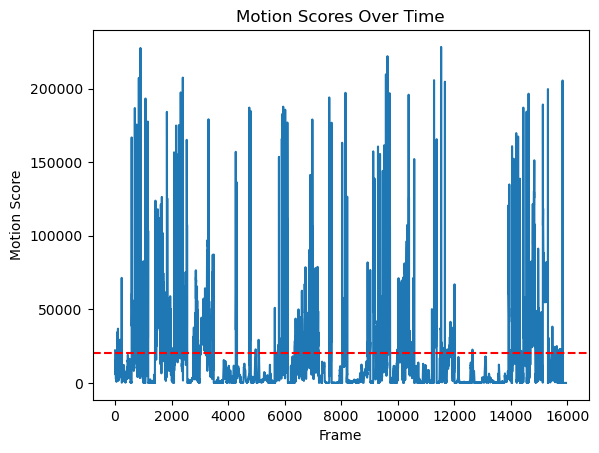

In [18]:
import matplotlib.pyplot as plt

frame_ids, scores = zip(*motion_scores)
plt.plot(frame_ids, scores)
plt.axhline(y=motion_threshold, color='r', linestyle='--')
plt.title("Motion Scores Over Time")
plt.xlabel("Frame")
plt.ylabel("Motion Score")
plt.show()
